<a href="https://colab.research.google.com/github/anandaero747/UMDAOSC650/blob/main/NN2_Outer_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing all libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

# Giving access to my google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This is the path in my gdrive where csv files are stored.
path  = '/content/drive/MyDrive/Colab Notebooks/NN_AOSC_Project/power_thrust_results.csv'

In [4]:
df = pd.read_csv(path)

In [5]:
df = df.dropna() # Dropping all nan values

# Identify and drop rows with negative values
df = df[(df >= 0).all(axis=1)]

In [6]:
df.shape

(1150, 5)

In [7]:
X = df[['uinf','omega']].copy() # Inputs are Wind Speed (uinf) and Turbine RPM (omega)
Y = df[['power','thrust']].copy() # Inputs are Power and Thrust

# Converting pandas dataframe for numpy arrays

In [8]:
X = X.to_numpy()
Y = Y.to_numpy()

In [9]:
X.shape

(1150, 2)

# Train Test and Split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Scaling X and Y using mean and standard deviation


In [11]:
scaler_X = preprocessing.StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)

scaler_Y = preprocessing.StandardScaler().fit(Y_train)
Y_train_std = scaler_Y.transform(Y_train)

##Note that the mean and std used for train data is used for scaling the test data as well.

In [12]:
X_test_std = scaler_X.transform(X_test)
Y_test_std = scaler_Y.transform(Y_test)

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(805, 2)
(805, 2)
(345, 2)
(345, 2)


# Defining the ANNs.
##A very simplistic ANNs is used with just two hidden layers each with 25 neurons. This is chosen intentionally as the data was generated using a low-fidelity code which usually has a simpler function approximation

In [16]:
model = Sequential()
model.add(Dense(25, input_dim = X_train_std.shape[1], activation = 'tanh'))
model.add(Dense(25, activation = 'tanh'))
model.add(Dense(Y_train_std.shape[1]))

model.compile(loss = 'mse', optimizer = 'adam')
fwd_model = model.fit(X_train_std,Y_train_std, batch_size=32, epochs=1000, validation_split=0.2, verbose = 0)

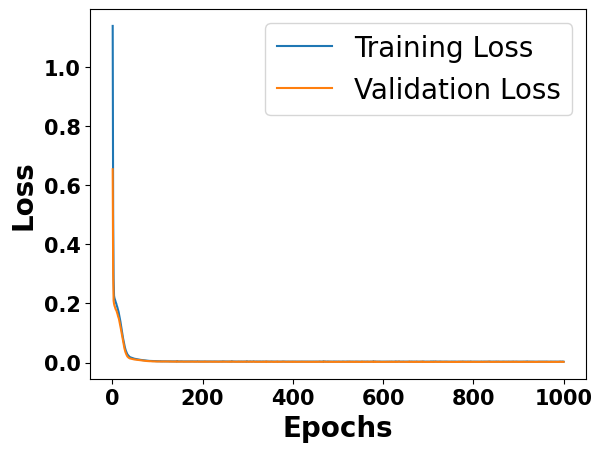

In [17]:
train_metrics = fwd_model.history['loss']
val_metrics = fwd_model.history['val_'+'loss']
epochs = range(1, len(train_metrics) + 1)
plt.plot(epochs, train_metrics)
plt.plot(epochs, val_metrics)
plt.xlabel("Epochs", fontsize=20,fontweight='bold')
plt.ylabel('Loss', fontsize=20,fontweight='bold')
plt.legend(["Training "+'Loss', 'Validation '+'Loss'], fontsize=20)
plt.xticks(fontsize=15,fontweight='bold')
plt.yticks(fontsize=15, fontweight = 'bold')
plt.show()

# The validation data and training data converge well

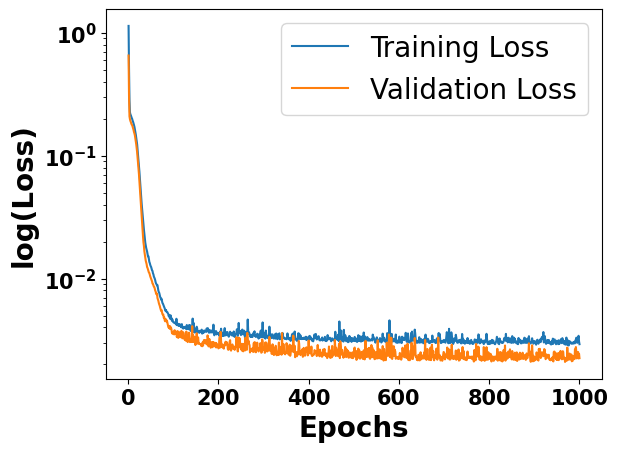

In [18]:
train_metrics = fwd_model.history['loss']
val_metrics = fwd_model.history['val_'+'loss']
epochs = range(1, len(train_metrics) + 1)
plt.semilogy(epochs, train_metrics)
plt.semilogy(epochs, val_metrics)
plt.xlabel("Epochs", fontsize=20,fontweight='bold')
plt.ylabel('log(Loss)', fontsize=20,fontweight='bold')
plt.legend(["Training "+'Loss', 'Validation '+'Loss'], fontsize=20)
plt.xticks(fontsize=15,fontweight='bold')
plt.yticks(fontsize=15, fontweight = 'bold')
plt.show()

# Evaluation of Test data from trained ANNs model

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [20]:
Y_pred_std = model.predict(X_test_std)

11/11 [==============================] - 0s 2ms/step


# Inverse scaling to re-transform to the original dimension

In [21]:
Y_pred_orig = scaler_Y.inverse_transform(Y_pred_std)
Y_test_orig = scaler_Y.inverse_transform(Y_test_std)

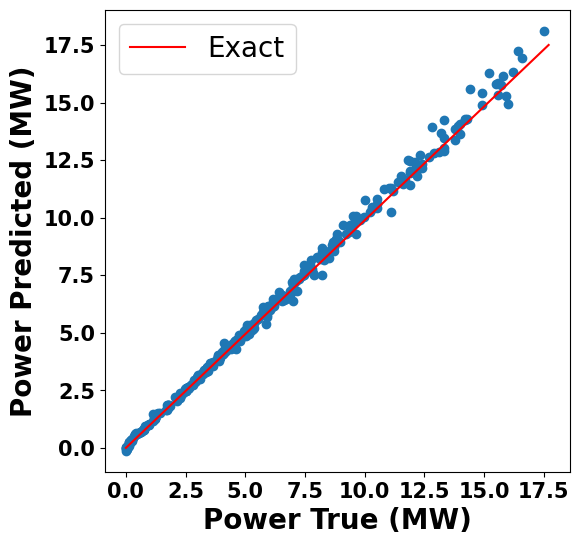

In [24]:
fig = plt.figure(figsize=(6,6))
plt.plot([0,17.7],[0,17.5], c = 'red')
plt.scatter(Y_test_orig[:,0:1]/1000000, Y_pred_orig[:,0:1]/1000000)
plt.xlabel("Power True (MW)", fontsize=20,fontweight='bold')
plt.ylabel("Power Predicted (MW)", fontsize=20,fontweight='bold')
plt.xticks(size = 15,fontweight='bold')
plt.yticks(size = 15,fontweight='bold')
plt.legend(['Exact'],fontsize=20)
plt.show()

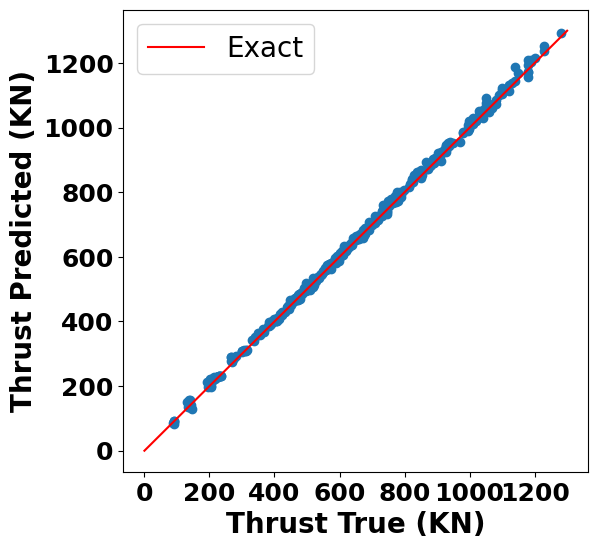

In [23]:
fig = plt.figure(figsize=(6,6))
plt.plot([0,1300],[0,1300], c = 'red')
plt.scatter(Y_test_orig[:,1:2]/1000, Y_pred_orig[:,1:2]/1000)
plt.xlabel("Thrust True (KN)", fontsize=20,fontweight='bold')
plt.ylabel("Thrust Predicted (KN)", fontsize=20,fontweight='bold')
plt.xticks(size = 18,fontweight='bold')
plt.yticks(size = 18,fontweight='bold')
plt.legend(['Exact'],fontsize=20)
plt.show()

# Evaluation of accuracy of ANNs

In [27]:
rmse = 0.0
for i in range(0, 1):
  rmse = rmse + np.sqrt(mean_squared_error(Y_test_orig[:,i], Y_pred_orig[:,i]))

rmse_final = rmse / Y_test_orig.shape[1]
print("RMSE of Power (MW) on test data: ", rmse_final/1e6)

RMSE of Power (MW) on test data:  0.1204165266839416


# Explorable AI for estimating the dependence of outputs on the corresponding inputs

In [ ]:
pip install shap


In [ ]:
import shap
import numpy as np
from tensorflow.keras.models import load_model

In [ ]:
def model_predict(data):
    return model.predict(data)

In [ ]:
explainer = shap.Explainer(model_predict, X_train_std)

In [ ]:
shap_values = explainer(X_test_std)

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:   6%|▋         | 22/345 [00:00<?, ?it/s]

10/10 [==============================] - 0s 5ms/step


ExactExplainer explainer:   7%|▋         | 24/345 [00:11<02:41,  1.99it/s]

10/10 [==============================] - 0s 8ms/step


ExactExplainer explainer:   7%|▋         | 25/345 [00:12<04:13,  1.26it/s]

10/10 [==============================] - 0s 5ms/step


ExactExplainer explainer:   8%|▊         | 26/345 [00:13<04:13,  1.26it/s]

10/10 [==============================] - 0s 5ms/step


ExactExplainer explainer:   8%|▊         | 27/345 [00:14<04:49,  1.10it/s]

10/10 [==============================] - 0s 7ms/step


ExactExplainer explainer:   8%|▊         | 28/345 [00:14<04:12,  1.25it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:   8%|▊         | 29/345 [00:15<03:45,  1.40it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:   9%|▊         | 30/345 [00:15<03:36,  1.46it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:   9%|▉         | 31/345 [00:16<03:21,  1.56it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:   9%|▉         | 32/345 [00:16<02:57,  1.76it/s]

10/10 [==============================] - 0s 5ms/step


ExactExplainer explainer:  10%|▉         | 33/345 [00:17<03:18,  1.57it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  10%|▉         | 34/345 [00:18<03:19,  1.56it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  10%|█         | 35/345 [00:18<02:59,  1.72it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  10%|█         | 36/345 [00:19<02:44,  1.87it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  11%|█         | 37/345 [00:19<02:31,  2.03it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  11%|█         | 38/345 [00:19<02:15,  2.27it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  11%|█▏        | 39/345 [00:20<02:03,  2.47it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  12%|█▏        | 40/345 [00:20<02:12,  2.29it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  12%|█▏        | 41/345 [00:21<02:20,  2.16it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  12%|█▏        | 42/345 [00:21<02:16,  2.23it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  12%|█▏        | 43/345 [00:21<02:06,  2.38it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  13%|█▎        | 44/345 [00:22<02:05,  2.40it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  13%|█▎        | 45/345 [00:22<02:13,  2.25it/s]

10/10 [==============================] - 0s 6ms/step


ExactExplainer explainer:  13%|█▎        | 46/345 [00:23<02:10,  2.29it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  14%|█▎        | 47/345 [00:23<02:21,  2.11it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  14%|█▍        | 48/345 [00:24<02:32,  1.95it/s]

10/10 [==============================] - 0s 7ms/step


ExactExplainer explainer:  14%|█▍        | 49/345 [00:25<02:54,  1.70it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  14%|█▍        | 50/345 [00:25<02:58,  1.65it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  15%|█▍        | 51/345 [00:26<03:23,  1.44it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  15%|█▌        | 52/345 [00:27<03:42,  1.32it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  15%|█▌        | 53/345 [00:28<03:45,  1.29it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  16%|█▌        | 54/345 [00:29<03:51,  1.26it/s]

10/10 [==============================] - 0s 7ms/step


ExactExplainer explainer:  16%|█▌        | 55/345 [00:29<03:16,  1.48it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  16%|█▌        | 56/345 [00:30<03:08,  1.53it/s]

10/10 [==============================] - 0s 8ms/step


ExactExplainer explainer:  17%|█▋        | 57/345 [00:30<02:52,  1.67it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  17%|█▋        | 58/345 [00:31<02:32,  1.89it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  17%|█▋        | 59/345 [00:31<02:15,  2.11it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  17%|█▋        | 60/345 [00:31<02:01,  2.35it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  18%|█▊        | 61/345 [00:32<01:44,  2.72it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  18%|█▊        | 62/345 [00:32<01:36,  2.94it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  18%|█▊        | 63/345 [00:32<01:26,  3.25it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  19%|█▊        | 64/345 [00:32<01:22,  3.40it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  19%|█▉        | 65/345 [00:33<01:19,  3.52it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  19%|█▉        | 66/345 [00:33<01:17,  3.59it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  19%|█▉        | 67/345 [00:33<01:13,  3.76it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  20%|█▉        | 68/345 [00:33<01:09,  3.96it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  20%|██        | 69/345 [00:34<01:07,  4.06it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  20%|██        | 70/345 [00:34<01:09,  3.98it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  21%|██        | 71/345 [00:34<01:10,  3.89it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  21%|██        | 72/345 [00:34<01:09,  3.93it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  21%|██        | 73/345 [00:35<01:10,  3.88it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  21%|██▏       | 74/345 [00:35<01:09,  3.91it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  22%|██▏       | 75/345 [00:35<01:10,  3.80it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  22%|██▏       | 76/345 [00:35<01:12,  3.71it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  22%|██▏       | 77/345 [00:36<01:15,  3.55it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  23%|██▎       | 78/345 [00:36<01:15,  3.52it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  23%|██▎       | 79/345 [00:36<01:15,  3.54it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  23%|██▎       | 80/345 [00:37<01:12,  3.67it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  23%|██▎       | 81/345 [00:37<01:11,  3.68it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  24%|██▍       | 82/345 [00:37<01:09,  3.80it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  24%|██▍       | 83/345 [00:37<01:09,  3.75it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  24%|██▍       | 84/345 [00:38<01:07,  3.89it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  25%|██▍       | 85/345 [00:38<01:05,  3.95it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  25%|██▍       | 86/345 [00:38<01:10,  3.65it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  25%|██▌       | 87/345 [00:38<01:13,  3.50it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  26%|██▌       | 88/345 [00:39<01:17,  3.33it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  26%|██▌       | 89/345 [00:39<01:17,  3.29it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  26%|██▌       | 90/345 [00:39<01:17,  3.29it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  26%|██▋       | 91/345 [00:40<01:15,  3.36it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  27%|██▋       | 92/345 [00:40<01:12,  3.47it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  27%|██▋       | 93/345 [00:40<01:10,  3.57it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  27%|██▋       | 94/345 [00:41<01:16,  3.30it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  28%|██▊       | 95/345 [00:41<01:21,  3.07it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  28%|██▊       | 96/345 [00:41<01:23,  2.99it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  28%|██▊       | 97/345 [00:42<01:19,  3.13it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  28%|██▊       | 98/345 [00:42<01:11,  3.46it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  29%|██▊       | 99/345 [00:42<01:06,  3.71it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  29%|██▉       | 100/345 [00:42<01:00,  4.04it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  29%|██▉       | 101/345 [00:43<01:00,  4.01it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  30%|██▉       | 102/345 [00:43<01:00,  4.00it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  30%|██▉       | 103/345 [00:43<00:59,  4.04it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  30%|███       | 104/345 [00:43<01:00,  3.96it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  30%|███       | 105/345 [00:44<01:01,  3.92it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  31%|███       | 106/345 [00:44<01:01,  3.88it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  31%|███       | 107/345 [00:44<01:00,  3.93it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  31%|███▏      | 108/345 [00:44<00:56,  4.16it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  32%|███▏      | 109/345 [00:44<00:58,  4.06it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  32%|███▏      | 110/345 [00:45<00:59,  3.92it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  32%|███▏      | 111/345 [00:45<01:03,  3.70it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  32%|███▏      | 112/345 [00:45<01:02,  3.72it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  33%|███▎      | 113/345 [00:46<01:01,  3.77it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  33%|███▎      | 114/345 [00:46<01:01,  3.76it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  33%|███▎      | 115/345 [00:46<00:58,  3.93it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  34%|███▎      | 116/345 [00:46<00:59,  3.86it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  34%|███▍      | 117/345 [00:47<00:59,  3.83it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  34%|███▍      | 118/345 [00:47<00:56,  4.01it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  34%|███▍      | 119/345 [00:47<00:52,  4.29it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  35%|███▍      | 120/345 [00:47<00:51,  4.38it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  35%|███▌      | 121/345 [00:48<00:52,  4.29it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  35%|███▌      | 122/345 [00:48<00:50,  4.39it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  36%|███▌      | 123/345 [00:48<00:53,  4.17it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  36%|███▌      | 124/345 [00:48<00:51,  4.26it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  36%|███▌      | 125/345 [00:48<00:49,  4.40it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  37%|███▋      | 126/345 [00:49<00:50,  4.34it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  37%|███▋      | 127/345 [00:49<00:50,  4.32it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  37%|███▋      | 128/345 [00:49<00:52,  4.13it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  37%|███▋      | 129/345 [00:49<00:53,  4.04it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  38%|███▊      | 130/345 [00:50<00:52,  4.06it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  38%|███▊      | 131/345 [00:50<00:52,  4.09it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  38%|███▊      | 132/345 [00:50<00:52,  4.04it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  39%|███▊      | 133/345 [00:50<00:51,  4.12it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  39%|███▉      | 134/345 [00:51<00:53,  3.96it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  39%|███▉      | 135/345 [00:51<00:51,  4.05it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  39%|███▉      | 136/345 [00:51<00:51,  4.06it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  40%|███▉      | 137/345 [00:51<00:48,  4.30it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  40%|████      | 138/345 [00:52<00:50,  4.11it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  40%|████      | 139/345 [00:52<00:53,  3.84it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  41%|████      | 140/345 [00:52<00:57,  3.59it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  41%|████      | 141/345 [00:53<00:55,  3.65it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  41%|████      | 142/345 [00:53<00:57,  3.52it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  41%|████▏     | 143/345 [00:53<01:01,  3.28it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  42%|████▏     | 144/345 [00:53<00:59,  3.37it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  42%|████▏     | 145/345 [00:54<00:58,  3.43it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  42%|████▏     | 146/345 [00:54<00:59,  3.36it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  43%|████▎     | 147/345 [00:54<01:01,  3.22it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  43%|████▎     | 148/345 [00:55<01:02,  3.17it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  43%|████▎     | 149/345 [00:55<01:01,  3.18it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  43%|████▎     | 150/345 [00:55<00:57,  3.38it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  44%|████▍     | 151/345 [00:55<00:53,  3.63it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  44%|████▍     | 152/345 [00:56<00:50,  3.79it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  44%|████▍     | 153/345 [00:56<00:50,  3.81it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  45%|████▍     | 154/345 [00:56<00:48,  3.97it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  45%|████▍     | 155/345 [00:56<00:48,  3.92it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  45%|████▌     | 156/345 [00:57<00:46,  4.09it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  46%|████▌     | 157/345 [00:57<00:45,  4.15it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  46%|████▌     | 158/345 [00:57<00:46,  4.05it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  46%|████▌     | 159/345 [00:57<00:44,  4.22it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  46%|████▋     | 160/345 [00:58<00:44,  4.20it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  47%|████▋     | 161/345 [00:58<00:45,  4.03it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  47%|████▋     | 162/345 [00:58<00:42,  4.30it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  47%|████▋     | 163/345 [00:58<00:41,  4.42it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  48%|████▊     | 164/345 [00:59<00:39,  4.61it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  48%|████▊     | 165/345 [00:59<00:40,  4.48it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  48%|████▊     | 166/345 [00:59<00:40,  4.43it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  48%|████▊     | 167/345 [00:59<00:42,  4.23it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  49%|████▊     | 168/345 [01:00<00:44,  4.01it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  49%|████▉     | 169/345 [01:00<00:41,  4.21it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  49%|████▉     | 170/345 [01:00<00:41,  4.23it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  50%|████▉     | 171/345 [01:00<00:42,  4.11it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  50%|████▉     | 172/345 [01:00<00:42,  4.03it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  50%|█████     | 173/345 [01:01<00:41,  4.12it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  50%|█████     | 174/345 [01:01<00:42,  4.01it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  51%|█████     | 175/345 [01:01<00:43,  3.87it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  51%|█████     | 176/345 [01:02<00:46,  3.67it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  51%|█████▏    | 177/345 [01:02<00:45,  3.70it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  52%|█████▏    | 178/345 [01:02<00:45,  3.69it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  52%|█████▏    | 179/345 [01:02<00:42,  3.93it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  52%|█████▏    | 180/345 [01:03<00:41,  4.01it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  52%|█████▏    | 181/345 [01:03<00:38,  4.23it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  53%|█████▎    | 182/345 [01:03<00:38,  4.21it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  53%|█████▎    | 183/345 [01:03<00:37,  4.34it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  53%|█████▎    | 184/345 [01:03<00:37,  4.24it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  54%|█████▎    | 185/345 [01:04<00:38,  4.18it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  54%|█████▍    | 186/345 [01:04<00:36,  4.35it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  54%|█████▍    | 187/345 [01:04<00:36,  4.31it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  54%|█████▍    | 188/345 [01:04<00:38,  4.12it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  55%|█████▍    | 189/345 [01:05<00:37,  4.12it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  55%|█████▌    | 190/345 [01:05<00:37,  4.15it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  55%|█████▌    | 191/345 [01:05<00:42,  3.62it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  56%|█████▌    | 192/345 [01:06<00:48,  3.13it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  56%|█████▌    | 193/345 [01:06<00:49,  3.06it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  56%|█████▌    | 194/345 [01:06<00:48,  3.13it/s]

10/10 [==============================] - 0s 5ms/step


ExactExplainer explainer:  57%|█████▋    | 195/345 [01:07<00:48,  3.10it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  57%|█████▋    | 196/345 [01:07<00:46,  3.20it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  57%|█████▋    | 197/345 [01:07<00:46,  3.19it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  57%|█████▋    | 198/345 [01:08<00:46,  3.17it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  58%|█████▊    | 199/345 [01:08<00:46,  3.17it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  58%|█████▊    | 200/345 [01:08<00:44,  3.24it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  58%|█████▊    | 201/345 [01:08<00:43,  3.31it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  59%|█████▊    | 202/345 [01:09<00:41,  3.44it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  59%|█████▉    | 203/345 [01:09<00:40,  3.53it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  59%|█████▉    | 204/345 [01:09<00:36,  3.84it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  59%|█████▉    | 205/345 [01:09<00:33,  4.14it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  60%|█████▉    | 206/345 [01:10<00:33,  4.13it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  60%|██████    | 207/345 [01:10<00:32,  4.27it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  60%|██████    | 208/345 [01:10<00:32,  4.24it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  61%|██████    | 209/345 [01:10<00:31,  4.25it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  61%|██████    | 210/345 [01:11<00:32,  4.14it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  61%|██████    | 211/345 [01:11<00:33,  3.96it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  61%|██████▏   | 212/345 [01:11<00:32,  4.05it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  62%|██████▏   | 213/345 [01:11<00:33,  3.95it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  62%|██████▏   | 214/345 [01:12<00:33,  3.95it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  62%|██████▏   | 215/345 [01:12<00:34,  3.78it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  63%|██████▎   | 216/345 [01:12<00:35,  3.65it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  63%|██████▎   | 217/345 [01:12<00:33,  3.88it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  63%|██████▎   | 218/345 [01:13<00:32,  3.87it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  63%|██████▎   | 219/345 [01:13<00:30,  4.11it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  64%|██████▍   | 220/345 [01:13<00:30,  4.14it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  64%|██████▍   | 221/345 [01:13<00:28,  4.32it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  64%|██████▍   | 222/345 [01:14<00:28,  4.35it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  65%|██████▍   | 223/345 [01:14<00:29,  4.16it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  65%|██████▍   | 224/345 [01:14<00:29,  4.12it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  65%|██████▌   | 225/345 [01:14<00:27,  4.34it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  66%|██████▌   | 226/345 [01:15<00:28,  4.20it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  66%|██████▌   | 227/345 [01:15<00:28,  4.08it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  66%|██████▌   | 228/345 [01:15<00:28,  4.17it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  66%|██████▋   | 229/345 [01:15<00:28,  4.05it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  67%|██████▋   | 230/345 [01:16<00:30,  3.77it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  67%|██████▋   | 231/345 [01:16<00:31,  3.65it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  67%|██████▋   | 232/345 [01:16<00:31,  3.58it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  68%|██████▊   | 233/345 [01:16<00:30,  3.68it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  68%|██████▊   | 234/345 [01:17<00:29,  3.79it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  68%|██████▊   | 235/345 [01:17<00:29,  3.74it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  68%|██████▊   | 236/345 [01:17<00:28,  3.87it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  69%|██████▊   | 237/345 [01:17<00:28,  3.82it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  69%|██████▉   | 238/345 [01:18<00:28,  3.75it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  69%|██████▉   | 239/345 [01:18<00:28,  3.75it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  70%|██████▉   | 240/345 [01:18<00:27,  3.86it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  70%|██████▉   | 241/345 [01:19<00:25,  4.01it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  70%|███████   | 242/345 [01:19<00:27,  3.75it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  70%|███████   | 243/345 [01:19<00:33,  3.03it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  71%|███████   | 244/345 [01:20<00:32,  3.09it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  71%|███████   | 245/345 [01:20<00:31,  3.14it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  71%|███████▏  | 246/345 [01:20<00:32,  3.07it/s]

10/10 [==============================] - 0s 5ms/step


ExactExplainer explainer:  72%|███████▏  | 247/345 [01:21<00:35,  2.79it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  72%|███████▏  | 248/345 [01:21<00:34,  2.80it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  72%|███████▏  | 249/345 [01:21<00:35,  2.67it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  72%|███████▏  | 250/345 [01:22<00:34,  2.78it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  73%|███████▎  | 251/345 [01:22<00:32,  2.86it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  73%|███████▎  | 252/345 [01:22<00:31,  2.93it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  73%|███████▎  | 253/345 [01:23<00:28,  3.25it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  74%|███████▎  | 254/345 [01:23<00:26,  3.39it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  74%|███████▍  | 255/345 [01:23<00:24,  3.61it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  74%|███████▍  | 256/345 [01:23<00:23,  3.74it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  74%|███████▍  | 257/345 [01:24<00:23,  3.68it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  75%|███████▍  | 258/345 [01:24<00:23,  3.70it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  75%|███████▌  | 259/345 [01:24<00:23,  3.63it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  75%|███████▌  | 260/345 [01:24<00:23,  3.70it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  76%|███████▌  | 261/345 [01:25<00:23,  3.52it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  76%|███████▌  | 262/345 [01:25<00:23,  3.53it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  76%|███████▌  | 263/345 [01:25<00:23,  3.43it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  77%|███████▋  | 264/345 [01:26<00:23,  3.47it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  77%|███████▋  | 265/345 [01:26<00:22,  3.49it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  77%|███████▋  | 266/345 [01:26<00:23,  3.38it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  77%|███████▋  | 267/345 [01:27<00:22,  3.48it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  78%|███████▊  | 268/345 [01:27<00:20,  3.80it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  78%|███████▊  | 269/345 [01:27<00:19,  3.96it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  78%|███████▊  | 270/345 [01:27<00:18,  4.06it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  79%|███████▊  | 271/345 [01:27<00:17,  4.20it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  79%|███████▉  | 272/345 [01:28<00:17,  4.20it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  79%|███████▉  | 273/345 [01:28<00:17,  4.22it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  79%|███████▉  | 274/345 [01:28<00:16,  4.38it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  80%|███████▉  | 275/345 [01:28<00:16,  4.31it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  80%|████████  | 276/345 [01:29<00:16,  4.27it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  80%|████████  | 277/345 [01:29<00:15,  4.27it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  81%|████████  | 278/345 [01:29<00:15,  4.27it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  81%|████████  | 279/345 [01:29<00:15,  4.35it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  81%|████████  | 280/345 [01:30<00:14,  4.34it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  81%|████████▏ | 281/345 [01:30<00:14,  4.29it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  82%|████████▏ | 282/345 [01:30<00:14,  4.31it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  82%|████████▏ | 283/345 [01:30<00:14,  4.29it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  82%|████████▏ | 284/345 [01:30<00:14,  4.09it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  83%|████████▎ | 285/345 [01:31<00:14,  4.02it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  83%|████████▎ | 286/345 [01:31<00:14,  4.12it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  83%|████████▎ | 287/345 [01:31<00:13,  4.16it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  83%|████████▎ | 288/345 [01:31<00:14,  4.01it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  84%|████████▍ | 289/345 [01:32<00:14,  3.95it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  84%|████████▍ | 290/345 [01:32<00:13,  4.05it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  84%|████████▍ | 291/345 [01:32<00:12,  4.21it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  85%|████████▍ | 292/345 [01:33<00:13,  3.88it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  85%|████████▍ | 293/345 [01:33<00:14,  3.61it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  85%|████████▌ | 294/345 [01:33<00:14,  3.58it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  86%|████████▌ | 295/345 [01:33<00:13,  3.65it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  86%|████████▌ | 296/345 [01:34<00:14,  3.45it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  86%|████████▌ | 297/345 [01:34<00:14,  3.33it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  86%|████████▋ | 298/345 [01:34<00:13,  3.36it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  87%|████████▋ | 299/345 [01:35<00:13,  3.38it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  87%|████████▋ | 300/345 [01:35<00:13,  3.34it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  87%|████████▋ | 301/345 [01:35<00:13,  3.23it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  88%|████████▊ | 302/345 [01:36<00:13,  3.24it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  88%|████████▊ | 303/345 [01:36<00:13,  3.16it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  88%|████████▊ | 304/345 [01:36<00:12,  3.25it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  88%|████████▊ | 305/345 [01:36<00:11,  3.46it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  89%|████████▊ | 306/345 [01:37<00:10,  3.74it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  89%|████████▉ | 307/345 [01:37<00:10,  3.74it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  89%|████████▉ | 308/345 [01:37<00:09,  3.88it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  90%|████████▉ | 309/345 [01:37<00:08,  4.01it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  90%|████████▉ | 310/345 [01:38<00:08,  4.24it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  90%|█████████ | 311/345 [01:38<00:08,  4.04it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  90%|█████████ | 312/345 [01:38<00:08,  3.91it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  91%|█████████ | 313/345 [01:38<00:08,  3.79it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  91%|█████████ | 314/345 [01:39<00:08,  3.67it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  91%|█████████▏| 315/345 [01:39<00:08,  3.74it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  92%|█████████▏| 316/345 [01:39<00:07,  3.91it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  92%|█████████▏| 317/345 [01:39<00:07,  3.90it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  92%|█████████▏| 318/345 [01:40<00:06,  4.03it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  92%|█████████▏| 319/345 [01:40<00:06,  3.86it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  93%|█████████▎| 320/345 [01:40<00:06,  3.72it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  93%|█████████▎| 321/345 [01:41<00:06,  3.66it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  93%|█████████▎| 322/345 [01:41<00:06,  3.64it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  94%|█████████▎| 323/345 [01:41<00:05,  3.80it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  94%|█████████▍| 324/345 [01:41<00:05,  3.99it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  94%|█████████▍| 325/345 [01:42<00:04,  4.04it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  94%|█████████▍| 326/345 [01:42<00:04,  4.24it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  95%|█████████▍| 327/345 [01:42<00:04,  4.34it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  95%|█████████▌| 328/345 [01:42<00:03,  4.30it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  95%|█████████▌| 329/345 [01:42<00:03,  4.12it/s]

10/10 [==============================] - 0s 4ms/step


ExactExplainer explainer:  96%|█████████▌| 330/345 [01:43<00:03,  4.03it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  96%|█████████▌| 331/345 [01:43<00:03,  4.16it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  96%|█████████▌| 332/345 [01:43<00:03,  4.16it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  97%|█████████▋| 333/345 [01:43<00:02,  4.03it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  97%|█████████▋| 334/345 [01:44<00:02,  4.12it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  97%|█████████▋| 335/345 [01:44<00:02,  4.01it/s]

10/10 [==============================] - 0s 8ms/step


ExactExplainer explainer:  97%|█████████▋| 336/345 [01:44<00:02,  3.48it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  98%|█████████▊| 337/345 [01:45<00:03,  2.18it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  98%|█████████▊| 338/345 [01:45<00:02,  2.54it/s]

10/10 [==============================] - 0s 5ms/step


ExactExplainer explainer:  98%|█████████▊| 339/345 [01:46<00:02,  2.37it/s]

10/10 [==============================] - 0s 2ms/step


ExactExplainer explainer:  99%|█████████▊| 340/345 [01:47<00:02,  1.79it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  99%|█████████▉| 341/345 [01:47<00:02,  1.94it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  99%|█████████▉| 342/345 [01:48<00:02,  1.44it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer:  99%|█████████▉| 343/345 [01:49<00:01,  1.73it/s]

10/10 [==============================] - 0s 3ms/step


ExactExplainer explainer: 100%|█████████▉| 344/345 [01:49<00:00,  2.04it/s]

10/10 [==============================] - 0s 8ms/step


ExactExplainer explainer: 100%|██████████| 345/345 [01:49<00:00,  2.05it/s]

10/10 [==============================] - 0s 9ms/step


ExactExplainer explainer: 346it [01:50,  2.93it/s]


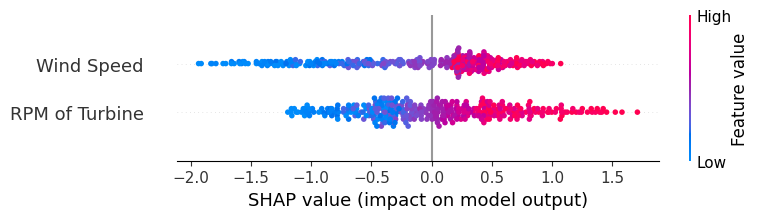

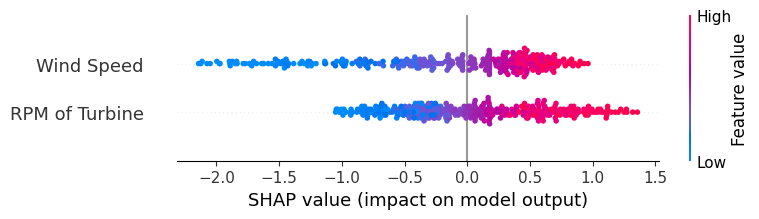

In [ ]:
# Visualize the SHAP values
import matplotlib.pyplot as plt
feature_names = ['Wind Speed', 'RPM of Turbine']
#shap_values.shape
shap.summary_plot(shap_values[:, :, 0], X_test, feature_names=feature_names)  # For the first output dimension
plt.show()

shap.summary_plot(shap_values[:, :, 1], X_test, feature_names=feature_names)  # For the second output dimension
plt.show()

###For 1st Output, Feature 0 has a very high negative contribution when it'a values are low, but has medium positive contribution when its values are high
  Feature 1 has very high +ve contribution when its values are high and intermediate negative contribution when its values are low
###For output 2
  Similar explanation as feature 1 as the plot looks identical

In [ ]:
# For 1st Output, Feature 0 has a very high negative contribution when it'a values are low, but has medium positive contribution when its values are high
  # Feature 1 has very high +ve contribution when its values are high and intermediate negative contribution when its values are low
# For output 2
  # Similar explanation as feature 1 as the plot looks identical

# Effect of uncertainity of Wind Speed on Power Generation

Defining a distribution of Wind Speed. 200 samples are generated from a random normal distribution between 0.8-1.2 * mean speed

In [ ]:
size_speed = 200 # Number of Wind Speed values sampled from distribution (0.8 to 1.2)
mean_speed = X_test[0,0]
min_speed = 0.80*mean_speed
max_speed = 1.20*mean_speed
sd_speed = (max_speed - min_speed)/4
speed_dist = np.random.normal(loc=mean_speed, scale=sd_speed, size=size_speed)
#speed_dist = speed_dist.reshape(200,1)
print(speed_dist.shape)

(200,)


In [ ]:
X_rpm = X_test[0,1].copy()
X_rpm_dist = np.tile(X_rpm, (200, 1))

In [ ]:
X_dist = np.concatenate((speed_dist,X_rpm_dist), axis = 1)
X_dist_std = scaler_X.transform(X_dist)

In [ ]:
Y_uncert_pred = model.predict(X_dist_std)
Y_uncert_pred_orig = scaler_Y.inverse_transform(Y_uncert_pred)

7/7 [==============================] - 0s 4ms/step


# Probability Density of Wind Speed

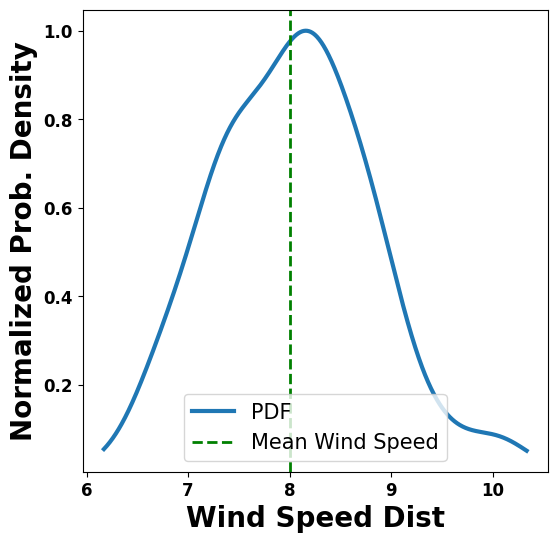

In [ ]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde



kde = gaussian_kde(speed_dist)

# Create a range of values for the x-axis
x_vals = np.linspace(speed_dist.min(), speed_dist.max(), 1000)

# Calculate the corresponding PDF values using the KDE
pdf_vals = kde.evaluate(x_vals)
pdf_vals_norm = pdf_vals / pdf_vals.max()
# Create a plot
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 15})
plt.plot(x_vals , pdf_vals_norm, label='PDF' ,linewidth=3.0)
plt.xlabel('Wind Speed Dist', fontsize=20,fontweight='bold')
plt.ylabel('Normalized Prob. Density', fontsize=20,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12, fontweight = 'bold')
plt.axvline(x=8, color='green', linestyle='--', label='Mean Wind Speed',linewidth=2)
plt.legend()

plt.show()

# Probability Density of Power Generated

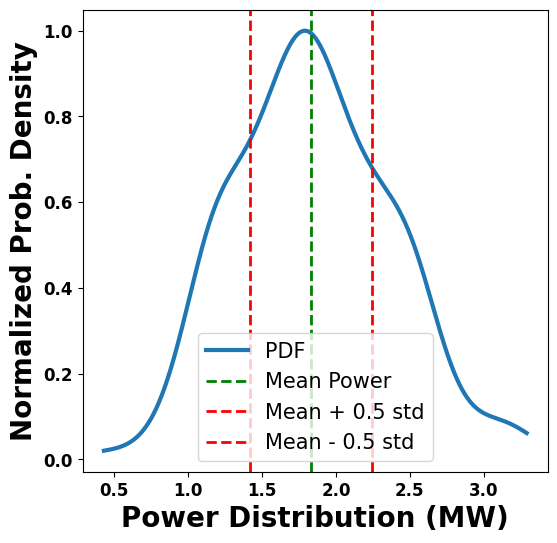

In [ ]:
power_uncert_pred_orig = np.squeeze(Y_uncert_pred_orig[:,0])
kde = gaussian_kde(power_uncert_pred_orig)


# Create a range of values for the x-axis
x_vals = np.linspace(power_uncert_pred_orig.min(), power_uncert_pred_orig.max(), 1000)

# Calculate the corresponding PDF values using the KDE
pdf_vals = kde.evaluate(x_vals)
pdf_vals_norm = pdf_vals / pdf_vals.max()
std_dev = np.std(x_vals)

# Create a plot
fig = plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 15})
plt.plot(x_vals/1000000 , pdf_vals_norm, label='PDF' ,linewidth=3.0)
plt.xlabel('Power Distribution (MW)', fontsize=20,fontweight='bold')
plt.ylabel('Normalized Prob. Density', fontsize=20,fontweight='bold')
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12, fontweight = 'bold')
plt.axvline(x=Y_pred_orig[0,0]/1000000, color='green', linestyle='--', label='Mean Power',linewidth=2)
plt.axvline(x=(Y_pred_orig[0,0] - 0.5 * std_dev)/1000000, color='red', linestyle='--', label='Mean + 0.5 std',linewidth=2)
plt.axvline(x=(Y_pred_orig[0,0] + 0.5 * std_dev)/1000000, color='red', linestyle='--', label='Mean - 0.5 std',linewidth=2)
plt.legend()
plt.show()